## 知識情報学第4回サンプルプログラム ex4.ipynb
- Programmed by Nattapong Thammasan, 監修　福井健一
- Last updated: 2021/10/26
- Checked with Python 3.8.8, scikit-learn 1.0
- MIT License

## ゴルフプレイデータのナイーブベイズ分類器による識別とROC,AUCによる評価
- データweather.nominal.arffは本プログラムと同じフォルダ内に置いておく

In [1]:
%matplotlib inline
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_curve,roc_auc_score,auc
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB

### arffデータの読み込み

In [2]:
f = open("weather.nominal.arff", "r", encoding="utf-8")
data, meta = arff.loadarff(f)
df_data= pd.DataFrame(data)
df_data

,outlook,temperature,humidity,windy,play
0,b'sunny',b'hot',b'high',b'FALSE',b'no'
1,b'sunny',b'hot',b'high',b'TRUE',b'no'
2,b'overcast',b'hot',b'high',b'FALSE',b'yes'
3,b'rainy',b'mild',b'high',b'FALSE',b'yes'
4,b'rainy',b'cool',b'normal',b'FALSE',b'yes'
5,b'rainy',b'cool',b'normal',b'TRUE',b'no'
6,b'overcast',b'cool',b'normal',b'TRUE',b'yes'
7,b'sunny',b'mild',b'high',b'FALSE',b'no'
8,b'sunny',b'cool',b'normal',b'FALSE',b'yes'
9,b'rainy',b'mild',b'normal',b'FALSE',b'yes'


### OrdinalEncoderを使ってラベル特徴を数値に変換
例えば，変数outlookの値{sunny, overcast, rainy}は，{0,1,2}に変換される

In [3]:
enc = OrdinalEncoder()
feature_encorded = enc.fit_transform(df_data.loc[:,['outlook','temperature', 'humidity', 'windy']])
class_encorded = np.ravel(enc.fit_transform(df_data.loc[:,['play']])) # np.ravel()で1次元化

feature_encorded, class_encorded

(array([[2., 1., 0., 0.],
        [2., 1., 0., 1.],
        [0., 1., 0., 0.],
        [1., 2., 0., 0.],
        [1., 0., 1., 0.],
        [1., 0., 1., 1.],
        [0., 0., 1., 1.],
        [2., 2., 0., 0.],
        [2., 0., 1., 0.],
        [1., 2., 1., 0.],
        [2., 2., 1., 1.],
        [0., 2., 0., 1.],
        [0., 1., 1., 0.],
        [1., 2., 0., 1.]]),
 array([0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.]))

### 1つ抜き交差検証（Leave-one-out cross-validation）
全N個のデータから1個を除いた(N-1)個を学習データとしてモデルを学習し，残りの1個でテストを行う．これをN回繰り返す．
- 【課題2】スムージングパラメータalphaを変更してみましょう．
- 【課題3】事前確率class_priorを変更してみましょう．

In [4]:
y_train_post_list,y_train_list,y_test_post_list,y_test_list = [],[],[],[]

loo = LeaveOneOut()
for train_index, test_index in loo.split(feature_encorded):
    X_train, X_test = feature_encorded[train_index], feature_encorded[test_index]
    y_train, y_test = class_encorded[train_index], class_encorded[test_index]

    # =====================================================================
    # 課題1(a) ナイーブベイズ分類器のインスタンスを生成し，学習データに適合させる．
    # カテゴリカルナイーブベイズ（CategoricalNB）を使用する．
    # https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html
    # alpha(>0)はスムージングのパラメータ．
    # fit_prior=Trueに指定すると学習データから事前確率を求める．
    # class_priorは，class_prior=[0.2,0.8]の形で事前確率を指定する．fit_prior=Falseのときに有効．
    
    model = CategoricalNB(alpha=1.0, fit_prior=True)
    model.fit(X_train, y_train)
    

    # =====================================================================
    # 課題1(b) 学習データとテストデータに対する各クラスの事後確率を算出
    # 学習データとテストデータに対する各クラスの事後確率を算出
    posterior_trn = model.predict_proba(X_train)
    posterior_tst = model.predict_proba(X_test)

    # テストデータの正解クラスと事後確率を出力
    print("True Label:", y_test)
    print("Posterior Probability:", posterior_tst)

    # 正解クラスと事後確率を保存
    y_train_post_list.extend(posterior_trn[:,[1]])
    y_train_list.extend(y_train)
    y_test_post_list.append(posterior_tst[0][1])
    y_test_list.extend(y_test)

True Label: [0.]
Posterior Probability: [[0.45539547 0.54460453]]
True Label: [0.]
Posterior Probability: [[0.68701207 0.31298793]]
True Label: [1.]
Posterior Probability: [[0.42974366 0.57025634]]
True Label: [1.]
Posterior Probability: [[0.60114784 0.39885216]]
True Label: [1.]
Posterior Probability: [[0.21132271 0.78867729]]
True Label: [0.]
Posterior Probability: [[0.05553006 0.94446994]]
True Label: [1.]
Posterior Probability: [[0.15155766 0.84844234]]
True Label: [0.]
Posterior Probability: [[0.33409552 0.66590448]]
True Label: [1.]
Posterior Probability: [[0.34891232 0.65108768]]
True Label: [1.]
Posterior Probability: [[0.23161973 0.76838027]]
True Label: [1.]
Posterior Probability: [[0.61651653 0.38348347]]
True Label: [1.]
Posterior Probability: [[0.50119624 0.49880376]]
True Label: [1.]
Posterior Probability: [[0.13097846 0.86902154]]
True Label: [0.]
Posterior Probability: [[0.39704676 0.60295324]]


### ROC曲線の描画とAUCの算出
- roc_curve
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
- roc_auc_score
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
- auc
    - 関数roc_auc_scoreの代わりに関数aucを使用してもよい
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc

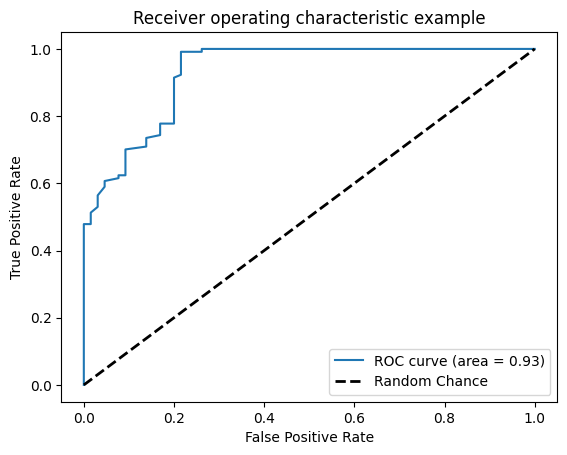

In [5]:
# 課題1(c) 学習データおよびテストデータに対するROC曲線の描画とAUCを算出する

fpr_trn, tpr_trn, thresholds_trn = roc_curve(y_train_list, y_train_post_list)
auc_trn = auc(fpr_trn, tpr_trn)

plt.plot(fpr_trn, tpr_trn, label='ROC curve (area = %.2f)'%auc_trn)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random Chance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()

In [22]:
def calc_roc(feature_encorded, class_encorded, alpha, fit_prior=True, class_prior=None):
    y_train_post_list,y_train_list,y_test_post_list,y_test_list = [],[],[],[]

    loo = LeaveOneOut()
    for train_index, test_index in loo.split(feature_encorded):
        X_train, X_test = feature_encorded[train_index], feature_encorded[test_index]
        y_train, y_test = class_encorded[train_index], class_encorded[test_index]
        
        model = CategoricalNB(alpha=alpha, fit_prior=fit_prior, force_alpha=True, class_prior=class_prior)
        model.fit(X_train, y_train)
        
        posterior_trn = model.predict_proba(X_train)
        posterior_tst = model.predict_proba(X_test)

        print(f"True Label:{y_test}, Posterior Probability:{posterior_tst}")

        y_train_post_list.extend(posterior_trn[:,[1]])
        y_train_list.extend(y_train)
        y_test_post_list.append(posterior_tst[0][1])
        y_test_list.extend(y_test)

    fpr_trn, tpr_trn, thresholds_trn = roc_curve(y_train_list, y_train_post_list)
    auc_trn = auc(fpr_trn, tpr_trn)

    plt.plot(fpr_trn, tpr_trn, label='ROC curve (area = %.2f)'%auc_trn)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random Chance')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

    plt.show()

### 課題2

- alphaを大きくするほどauc scoreは小さくなった。これはalphaが大きいほど元のデータ分布への変更が大きくなり、train dataとtest dataでデータ分布の差が発生したためだと考えられる。
- alpha=0の時にauc scoreは最も大きい値をとった。今回はleave one out法で評価を行うため、ゼロ頻度問題が発生するのはセルの値が0のデータ（temperture=coolまたはhumidity=normalでno）がテストデータに選ばれた場合だけだが、これらのデータでは元々noである確率が低くゼロ頻度問題が発生していなくてもyesと予測されがちなため、ゼロ頻度問題による予測精度の低下が観測されなかったものと思われる
- alphaを大きくするほどROC curveは滑らかになり、異なる閾値に対してより一貫した性能を発揮するようになっていることが見受けられる。

True Label:[0.], Posterior Probability:[[0.48697395 0.51302605]]
True Label:[0.], Posterior Probability:[[0.79153094 0.20846906]]
True Label:[1.], Posterior Probability:[[0. 1.]]
True Label:[1.], Posterior Probability:[[0.68598225 0.31401775]]
True Label:[1.], Posterior Probability:[[0.14077536 0.85922464]]
True Label:[0.], Posterior Probability:[[0. 1.]]
True Label:[1.], Posterior Probability:[[0. 1.]]
True Label:[0.], Posterior Probability:[[0.3218543 0.6781457]]
True Label:[1.], Posterior Probability:[[0.32954302 0.67045698]]
True Label:[1.], Posterior Probability:[[0.1792874 0.8207126]]
True Label:[1.], Posterior Probability:[[0.71078205 0.28921795]]
True Label:[1.], Posterior Probability:[[0. 1.]]
True Label:[1.], Posterior Probability:[[0. 1.]]
True Label:[0.], Posterior Probability:[[0.38755981 0.61244019]]


/Users/wadatetsuya/Documents/work/lecture-knowledgeinformation/venv/lib/python3.11/site-packages/sklearn/naive_bayes.py:1517: RuntimeWarning: divide by zero encountered in log
  np.log(smoothed_cat_count) - np.log(smoothed_class_count.reshape(-1, 1))
/Users/wadatetsuya/Documents/work/lecture-knowledgeinformation/venv/lib/python3.11/site-packages/sklearn/naive_bayes.py:1517: RuntimeWarning: divide by zero encountered in log
  np.log(smoothed_cat_count) - np.log(smoothed_class_count.reshape(-1, 1))
/Users/wadatetsuya/Documents/work/lecture-knowledgeinformation/venv/lib/python3.11/site-packages/sklearn/naive_bayes.py:1517: RuntimeWarning: divide by zero encountered in log
  np.log(smoothed_cat_count) - np.log(smoothed_class_count.reshape(-1, 1))
/Users/wadatetsuya/Documents/work/lecture-knowledgeinformation/venv/lib/python3.11/site-packages/sklearn/naive_bayes.py:1517: RuntimeWarning: divide by zero encountered in log
  np.log(smoothed_cat_count) - np.log(smoothed_class_count.reshape(-1, 

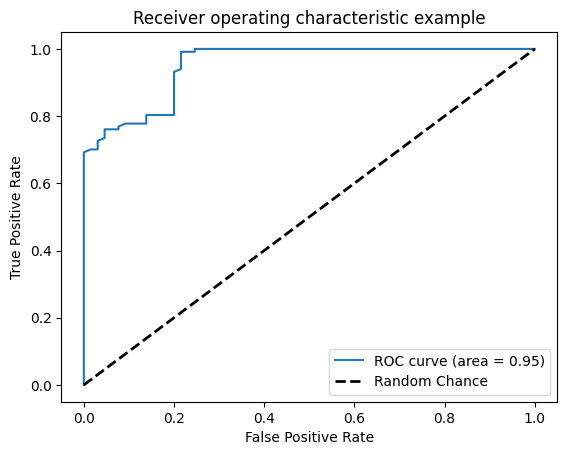

In [23]:
calc_roc(feature_encorded, class_encorded, alpha=0)

True Label:[0.], Posterior Probability:[[0.48512956 0.51487044]]
True Label:[0.], Posterior Probability:[[0.77971641 0.22028359]]
True Label:[1.], Posterior Probability:[[0.15874859 0.84125141]]
True Label:[1.], Posterior Probability:[[0.67487691 0.32512309]]
True Label:[1.], Posterior Probability:[[0.15061113 0.84938887]]
True Label:[0.], Posterior Probability:[[0.0012664 0.9987336]]
True Label:[1.], Posterior Probability:[[0.020094 0.979906]]
True Label:[0.], Posterior Probability:[[0.32551324 0.67448676]]
True Label:[1.], Posterior Probability:[[0.33320517 0.66679483]]
True Label:[1.], Posterior Probability:[[0.18653963 0.81346037]]
True Label:[1.], Posterior Probability:[[0.69850868 0.30149132]]
True Label:[1.], Posterior Probability:[[0.19358329 0.80641671]]
True Label:[1.], Posterior Probability:[[0.02042121 0.97957879]]
True Label:[0.], Posterior Probability:[[0.39147245 0.60852755]]


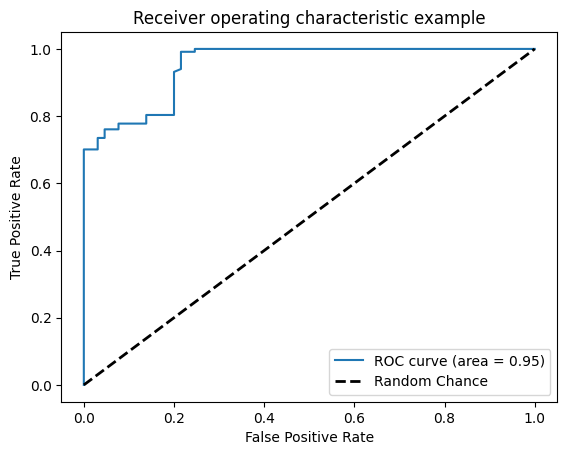

In [24]:
calc_roc(feature_encorded, class_encorded, alpha=0.1)

True Label:[0.], Posterior Probability:[[0.47289056 0.52710944]]
True Label:[0.], Posterior Probability:[[0.73522976 0.26477024]]
True Label:[1.], Posterior Probability:[[0.36915365 0.63084635]]
True Label:[1.], Posterior Probability:[[0.63709158 0.36290842]]
True Label:[1.], Posterior Probability:[[0.18262544 0.81737456]]
True Label:[0.], Posterior Probability:[[0.02133144 0.97866856]]
True Label:[1.], Posterior Probability:[[0.08950934 0.91049066]]
True Label:[0.], Posterior Probability:[[0.33262622 0.66737378]]
True Label:[1.], Posterior Probability:[[0.34268262 0.65731738]]
True Label:[1.], Posterior Probability:[[0.21010265 0.78989735]]
True Label:[1.], Posterior Probability:[[0.65654175 0.34345825]]
True Label:[1.], Posterior Probability:[[0.4358019 0.5641981]]
True Label:[1.], Posterior Probability:[[0.08144162 0.91855838]]
True Label:[0.], Posterior Probability:[[0.39800995 0.60199005]]


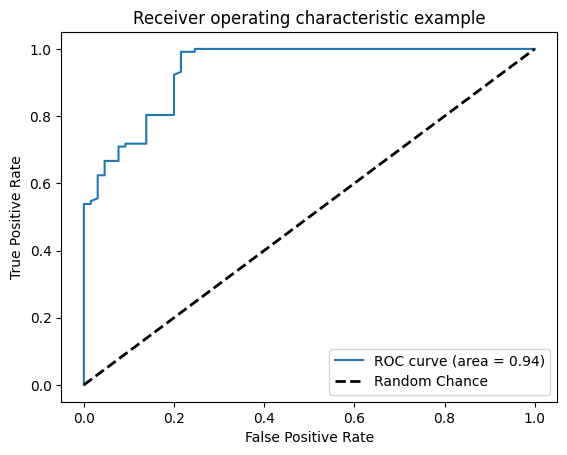

In [25]:
calc_roc(feature_encorded, class_encorded, alpha=0.5)

True Label:[0.], Posterior Probability:[[0.45539547 0.54460453]]
True Label:[0.], Posterior Probability:[[0.68701207 0.31298793]]
True Label:[1.], Posterior Probability:[[0.42974366 0.57025634]]
True Label:[1.], Posterior Probability:[[0.60114784 0.39885216]]
True Label:[1.], Posterior Probability:[[0.21132271 0.78867729]]
True Label:[0.], Posterior Probability:[[0.05553006 0.94446994]]
True Label:[1.], Posterior Probability:[[0.15155766 0.84844234]]
True Label:[0.], Posterior Probability:[[0.33409552 0.66590448]]
True Label:[1.], Posterior Probability:[[0.34891232 0.65108768]]
True Label:[1.], Posterior Probability:[[0.23161973 0.76838027]]
True Label:[1.], Posterior Probability:[[0.61651653 0.38348347]]
True Label:[1.], Posterior Probability:[[0.50119624 0.49880376]]
True Label:[1.], Posterior Probability:[[0.13097846 0.86902154]]
True Label:[0.], Posterior Probability:[[0.39704676 0.60295324]]


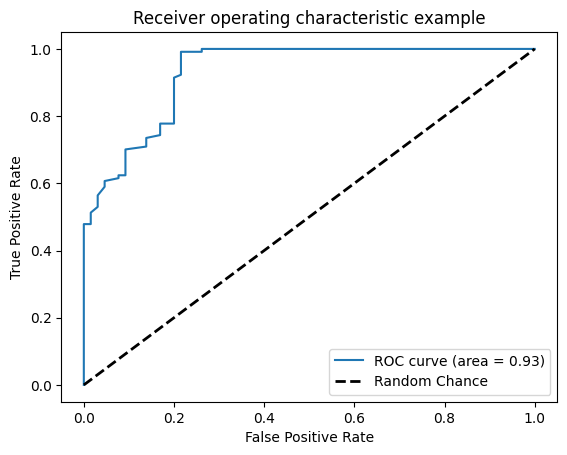

In [15]:
calc_roc(feature_encorded, class_encorded, alpha=1.0)

### 課題3
- class_priorを変更すると、事後確率は大きく影響を受けたが、ROC curveはほとんど変化しなかった

True Label:[0.], Posterior Probability:[[0.31989425 0.68010575]]
True Label:[0.], Posterior Probability:[[0.55251142 0.44748858]]
True Label:[1.], Posterior Probability:[[0.23161973 0.76838027]]
True Label:[1.], Posterior Probability:[[0.37612215 0.62387785]]
True Label:[1.], Posterior Probability:[[0.0968031 0.9031969]]
True Label:[0.], Posterior Probability:[[0.03201341 0.96798659]]
True Label:[1.], Posterior Probability:[[0.06668724 0.93331276]]
True Label:[0.], Posterior Probability:[[0.22010005 0.77989995]]
True Label:[1.], Posterior Probability:[[0.17651864 0.82348136]]
True Label:[1.], Posterior Probability:[[0.10760147 0.89239853]]
True Label:[1.], Posterior Probability:[[0.3913831 0.6086169]]
True Label:[1.], Posterior Probability:[[0.28669181 0.71330819]]
True Label:[1.], Posterior Probability:[[0.05685983 0.94314017]]
True Label:[0.], Posterior Probability:[[0.27029039 0.72970961]]


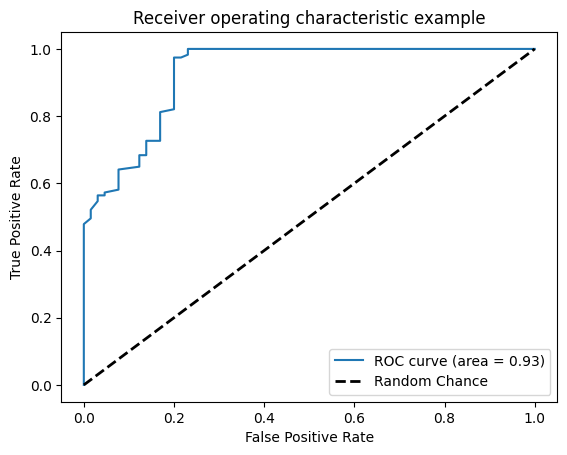

In [26]:
calc_roc(feature_encorded, class_encorded, alpha=1, fit_prior=False, class_prior=[0.2,0.8])

True Label:[0.], Posterior Probability:[[0.6529511 0.3470489]]
True Label:[0.], Posterior Probability:[[0.83161512 0.16838488]]
True Label:[1.], Posterior Probability:[[0.54664064 0.45335936]]
True Label:[1.], Posterior Probability:[[0.7068748 0.2931252]]
True Label:[1.], Posterior Probability:[[0.30006944 0.69993056]]
True Label:[0.], Posterior Probability:[[0.11683296 0.88316704]]
True Label:[1.], Posterior Probability:[[0.22227937 0.77772063]]
True Label:[0.], Posterior Probability:[[0.53026568 0.46973432]]
True Label:[1.], Posterior Probability:[[0.46162063 0.53837937]]
True Label:[1.], Posterior Probability:[[0.32537378 0.67462622]]
True Label:[1.], Posterior Probability:[[0.72006665 0.27993335]]
True Label:[1.], Posterior Probability:[[0.61651653 0.38348347]]
True Label:[1.], Posterior Probability:[[0.19429636 0.80570364]]
True Label:[0.], Posterior Probability:[[0.59703947 0.40296053]]


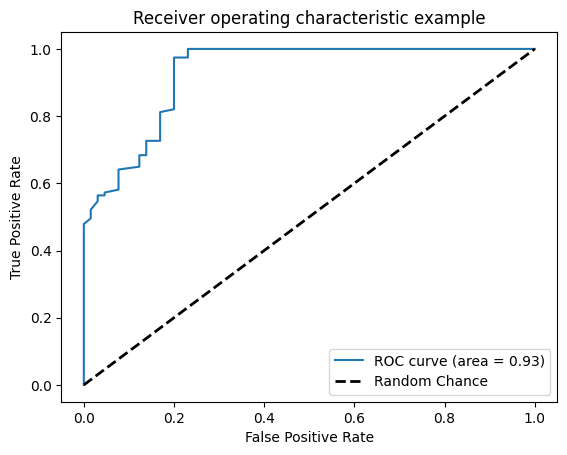

In [27]:
calc_roc(feature_encorded, class_encorded, alpha=1, fit_prior=False, class_prior=[0.5,0.5])

True Label:[0.], Posterior Probability:[[0.88270831 0.11729169]]
True Label:[0.], Posterior Probability:[[0.95181908 0.04818092]]
True Label:[1.], Posterior Probability:[[0.82826789 0.17173211]]
True Label:[1.], Posterior Probability:[[0.90606841 0.09393159]]
True Label:[1.], Posterior Probability:[[0.63165588 0.36834412]]
True Label:[0.], Posterior Probability:[[0.34604385 0.65395615]]
True Label:[1.], Posterior Probability:[[0.53341562 0.46658438]]
True Label:[0.], Posterior Probability:[[0.81869119 0.18130881]]
True Label:[1.], Posterior Probability:[[0.77425134 0.22574866]]
True Label:[1.], Posterior Probability:[[0.65861093 0.34138907]]
True Label:[1.], Posterior Probability:[[0.9114191 0.0885809]]
True Label:[1.], Posterior Probability:[[0.86542313 0.13457687]]
True Label:[1.], Posterior Probability:[[0.49099172 0.50900828]]
True Label:[0.], Posterior Probability:[[0.85562758 0.14437242]]


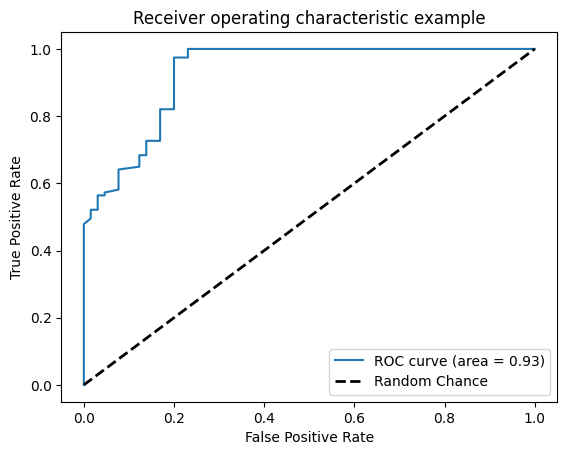

In [28]:
calc_roc(feature_encorded, class_encorded, alpha=1, fit_prior=False, class_prior=[0.8,0.2])